In [6]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "../DatasetGFT"
ACTIVITY_LABELS = [0, 1, 2, 3, 4, 5]
ACTIVITY_NAMES = [
    "Rest",
    "Fold clothes",
    "Sweep",
    "Walk",
    "Move boxes",
    "Bike"
]
SAMPLING_RATE = 100
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_enu", "ay_enu", "az_enu", "gx_enu", "gy_enu", "gz_enu"]

In [2]:
def load_gft_csvs(base_dir):
    subject_dfs = {}
    for subject_id in sorted(os.listdir(base_dir)):
        subject_path = os.path.join(base_dir, subject_id)
        if not os.path.isdir(subject_path):
            continue
        csv_files = glob.glob(
            os.path.join(subject_path, "IMU_GFT_*.csv")
        )
        if len(csv_files) == 0:
            continue
        subject_dfs[subject_id] = pd.read_csv(csv_files[0])
    print(f"Loaded {len(subject_dfs)} subjects")
    return subject_dfs


def split_subjects_60_20_20(subject_dfs):
    subjects = list(subject_dfs.keys())
    np.random.shuffle(subjects)
    n_total = len(subjects)
    n_train = int(0.6 * n_total)
    n_val = int(0.2 * n_total)
    train_subjects = subjects[:n_train]
    val_subjects = subjects[n_train:n_train + n_val]
    test_subjects = subjects[n_train + n_val:]
    print(f"Train subjects: {len(train_subjects)}")
    print(f"Val subjects:   {len(val_subjects)}")
    print(f"Test subjects:  {len(test_subjects)}")
    return (
        [subject_dfs[s] for s in train_subjects],
        [subject_dfs[s] for s in val_subjects],
        [subject_dfs[s] for s in test_subjects],
    )

In [3]:
def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]


def extract_features(window, cols):
    """Optimized feature extraction with vectorized operations"""
    feats = []
    # Extract all columns at once as numpy array
    data = window[cols].values
    
    for i in range(len(cols)):
        x = data[:, i]
        
        # Time-domain features (vectorized)
        mean_x = np.mean(x)
        std_x = np.std(x)
        feats.extend([
            mean_x,
            std_x,
            np.min(x),
            np.max(x),
            np.sqrt(np.mean(x ** 2)),  # RMS
            np.mean(np.abs(x))
        ])
        
        # Frequency-domain features
        fft_mag = np.abs(np.fft.rfft(x))
        feats.extend([
            np.mean(fft_mag),
            np.std(fft_mag),
            np.max(fft_mag),
            np.sum(fft_mag)
        ])
    return feats


def build_dataset(dfs, feature_cols):
    X, y = [], []
    for df in dfs:
        df = df[feature_cols + ["label"]]
        for w in sliding_windows(df):
            X.append(extract_features(w, feature_cols))
            y.append(w["label"].iloc[0])
    return np.array(X), np.array(y)


def balance_classes_undersample(X, y, random_state=42):
    np.random.seed(random_state)
    X_balanced = []
    y_balanced = []
    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    print("Class counts before balancing:")
    for c, cnt in zip(classes, counts):
        print(f"  Class {c}: {cnt}")
    for cls in classes:
        idx = np.where(y == cls)[0]
        selected_idx = np.random.choice(idx, size=min_count, replace=False)
        X_balanced.append(X[selected_idx])
        y_balanced.append(y[selected_idx])
    X_balanced = np.vstack(X_balanced)
    y_balanced = np.concatenate(y_balanced)
    perm = np.random.permutation(len(y_balanced))
    X_balanced = X_balanced[perm]
    y_balanced = y_balanced[perm]
    print(f"\nBalanced each class to {min_count} samples")
    return X_balanced, y_balanced

In [5]:
def balance_classes_undersample(X, y, random_state=42):
    np.random.seed(random_state)

    X_balanced = []
    y_balanced = []

    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    print("Class counts before balancing:")
    for c, cnt in zip(classes, counts):
        print(f"  Class {c}: {cnt}")

    for cls in classes:
        idx = np.where(y == cls)[0]
        selected_idx = np.random.choice(idx, size=min_count, replace=False)

        X_balanced.append(X[selected_idx])
        y_balanced.append(y[selected_idx])

    X_balanced = np.vstack(X_balanced)
    y_balanced = np.concatenate(y_balanced)

    perm = np.random.permutation(len(y_balanced))
    X_balanced = X_balanced[perm]
    y_balanced = y_balanced[perm]

    print(f"\nBalanced each class to {min_count} samples")

    return X_balanced, y_balanced

In [4]:
def select_svm_on_validation(X_train, y_train, X_val, y_val):
    params = {
        "alpha": 0.0001,
    }
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SGDClassifier(
            loss='hinge', 
            alpha=params["alpha"],
            max_iter=1000,
            tol=1e-3,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])
    
    print("Training SVM with SGDClassifier (much faster than LinearSVC)...")
    pipeline.fit(X_train, y_train)
    
    y_val_pred = pipeline.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average="macro")
    
    print("Using SGDClassifier parameters:", params)
    print(f"Validation F1: {f1:.4f}")
    
    return pipeline, params


def evaluate_on_test(pipeline, X_test, y_test, title):
    """Evaluate already-fitted pipeline on test set"""
    y_pred = pipeline.predict(X_test)
    
    print(f"\n=== {title} ===")
    print(classification_report(
        y_test, y_pred,
        target_names=ACTIVITY_NAMES,
        digits=4
    ))
    
    cm = confusion_matrix(y_test, y_pred, labels=ACTIVITY_LABELS)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=ACTIVITY_NAMES,
        yticklabels=ACTIVITY_NAMES,
        cmap="Blues"
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return {
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1": f1_score(y_test, y_pred, average="macro")
    }

Loaded 60 subjects
Train subjects: 36
Val subjects:   12
Test subjects:  12

Processing RAW IMU features
Class counts before balancing:
  Class 0.0: 24216
  Class 1.0: 10894
  Class 2.0: 10617
  Class 3.0: 10632
  Class 4.0: 10384
  Class 5.0: 10502

Balanced each class to 10384 samples
Training SVM with SGDClassifier (much faster than LinearSVC)...
Using SGDClassifier parameters: {'alpha': 0.0001}
Validation F1: 0.7143

=== SVM – Raw IMU Frame ===
              precision    recall  f1-score   support

        Rest     0.7775    0.5560    0.6483      7829
Fold clothes     0.4556    0.7489    0.5666      3612
       Sweep     0.6753    0.6507    0.6628      3564
        Walk     0.8500    0.8432    0.8466      3502
  Move boxes     0.7518    0.7850    0.7680      3484
        Bike     0.7224    0.7037    0.7129      3527

    accuracy                         0.6876     25518
   macro avg     0.7054    0.7146    0.7009     25518
weighted avg     0.7165    0.6876    0.6913     25518



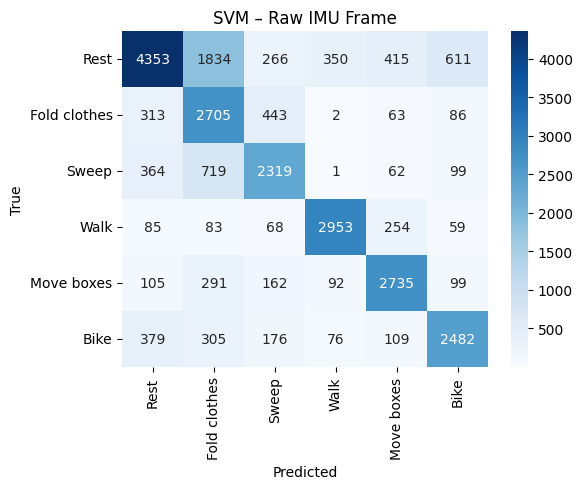


Processing GFT (Global Frame) features
Class counts before balancing:
  Class 0.0: 24216
  Class 1.0: 10894
  Class 2.0: 10617
  Class 3.0: 10632
  Class 4.0: 10384
  Class 5.0: 10502

Balanced each class to 10384 samples
Training SVM with SGDClassifier (much faster than LinearSVC)...
Using SGDClassifier parameters: {'alpha': 0.0001}
Validation F1: 0.6801

=== SVM – Global Frame (ENU) ===
              precision    recall  f1-score   support

        Rest     0.7582    0.6714    0.7121      7829
Fold clothes     0.5487    0.6467    0.5937      3612
       Sweep     0.5778    0.4627    0.5139      3564
        Walk     0.7371    0.7607    0.7487      3502
  Move boxes     0.6459    0.6665    0.6560      3484
        Bike     0.5614    0.6790    0.6147      3527

    accuracy                         0.6514     25518
   macro avg     0.6382    0.6478    0.6399     25518
weighted avg     0.6579    0.6514    0.6516     25518



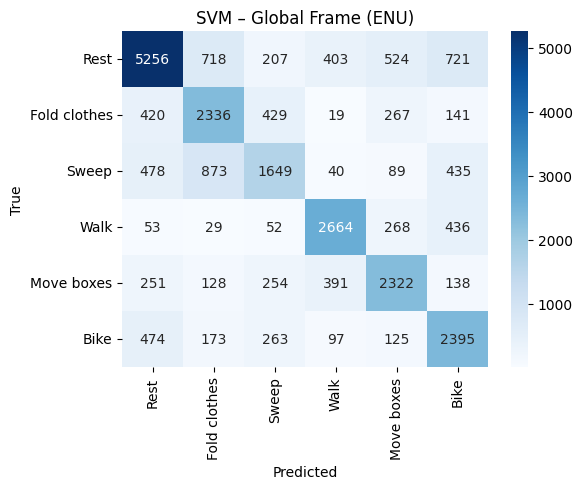


FINAL RESULTS SUMMARY
Raw Frame:    Precision=0.7054, Recall=0.7146, F1=0.7009
Global Frame: Precision=0.6382, Recall=0.6478, F1=0.6399


In [7]:
if __name__ == "__main__":
    subject_dfs = load_gft_csvs(DATA_DIR)
    train_dfs, val_dfs, test_dfs = split_subjects_60_20_20(subject_dfs)
    
    print("\n" + "="*50)
    print("Processing RAW IMU features")
    print("="*50)
    
    X_train_raw, y_train_raw = build_dataset(train_dfs, RAW_FEATURES)
    X_train_raw, y_train_raw = balance_classes_undersample(
        X_train_raw, y_train_raw, random_state=RANDOM_STATE
    )
    X_val_raw, y_val_raw = build_dataset(val_dfs, RAW_FEATURES)
    X_test_raw, y_test_raw = build_dataset(test_dfs, RAW_FEATURES)
    
    raw_pipeline, raw_params = select_svm_on_validation(
        X_train_raw, y_train_raw,
        X_val_raw, y_val_raw
    )
    
    raw_metrics = evaluate_on_test(
        raw_pipeline,
        X_test_raw, y_test_raw,
        "SVM – Raw IMU Frame"
    )
    
    print("\n" + "="*50)
    print("Processing GFT (Global Frame) features")
    print("="*50)
    
    X_train_gft, y_train_gft = build_dataset(train_dfs, GFT_FEATURES)
    X_train_gft, y_train_gft = balance_classes_undersample(
        X_train_gft, y_train_gft, random_state=RANDOM_STATE
    )
    X_val_gft, y_val_gft = build_dataset(val_dfs, GFT_FEATURES)
    X_test_gft, y_test_gft = build_dataset(test_dfs, GFT_FEATURES)
    
    gft_pipeline, gft_params = select_svm_on_validation(
        X_train_gft, y_train_gft,
        X_val_gft, y_val_gft
    )
    
    gft_metrics = evaluate_on_test(
        gft_pipeline,
        X_test_gft, y_test_gft,
        "SVM – Global Frame (ENU)"
    )
    
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"Raw Frame:    Precision={raw_metrics['precision']:.4f}, "
          f"Recall={raw_metrics['recall']:.4f}, F1={raw_metrics['f1']:.4f}")
    print(f"Global Frame: Precision={gft_metrics['precision']:.4f}, "
          f"Recall={gft_metrics['recall']:.4f}, F1={gft_metrics['f1']:.4f}")